Bitcoin Price Prediction Using Time Series Forecasting
================

In [2]:
import pandas as pd
import numpy as np
import pylab
import matplotlib.pyplot as plt
from collections import Counter
import re

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('data/BTC-USD.csv')
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-03-31,92.190002,93.800003,91.000000,93.029999,93.029999,1959050
1,2013-04-01,93.029999,106.000000,92.239998,104.000000,104.000000,9060022
2,2013-04-02,104.000000,118.360001,99.000000,117.980003,117.980003,8747147
3,2013-04-03,117.980003,147.000000,110.000000,135.000000,135.000000,19533010
4,2013-04-04,135.000000,142.119995,116.389999,132.119995,132.119995,11624021


Plotting the time series
--------

<class 'pandas.core.frame.DataFrame'>
                 Close
Date                  
2013-03-31   93.029999
2013-04-01  104.000000
2013-04-02  117.980003
2013-04-03  135.000000
2013-04-04  132.119995


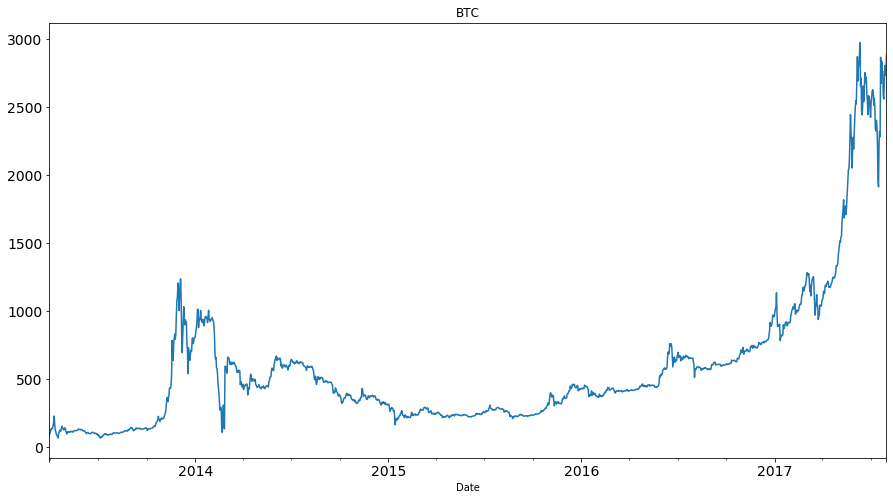

In [24]:
import matplotlib.dates as mdates

data = train['Close']
Date1 = train['Date']
train1 = train[['Date', 'Close']]
train2 = train1.set_index('Date')
train2.sort_index(inplace = True)
print(type(train2))
print(train2.head())

train2.Timestamp = pd.to_datetime(train2.reset_index().Date, format='%Y-%m-%d')
train2.index = train2.Timestamp
train2.Close.plot(figsize=(15,8), title = 'BTC', fontsize=14)
plt.show()

# plt.figure(figsize=(16, 10))
# plt.plot(train2)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Price in USD', fontsize=12)
# plt.title('Closing price distribution of bitcoin', fontsize=15)
# plt.show()

Testing the Stationarity
------------
#### (Augmented Dicky Fuller Test)  

#### 1. Null Hypothesis (H0):   
Null hypothesis of the test is that the time series can be represented by a unit root that is not stationary.  

#### 2. Alternative Hypothesis (H1):   
Alternative Hypothesis of the test is that the time series is stationary.  

#### Interpretation of p value
1. p value > 0.05: Accepts the Null Hypothesis (H0), the data has a unit root and is non-stationary.  
2. p value < = 0.05: Rejects the Null Hypothesis (H0), the data is stationary.  

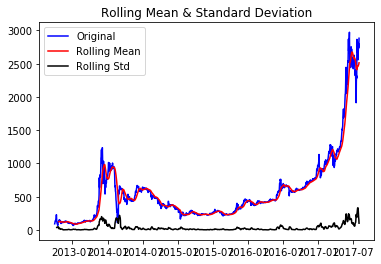

ADF Stastistic: 2.286309
p-value: 0.998946
The graph is non stationery
Critical values:
	1%: -3.435 
	5%: -2.863 
	10%: -2.568 


In [26]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):

    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()
    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plt.plot(x, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
        
ts = train2['Close']      
test_stationarity(ts)

Log Transforming the series
---------

#### Skewed된 데이터를 unskewed하게 변환시키기 위한 작업  

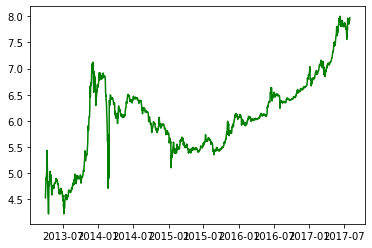

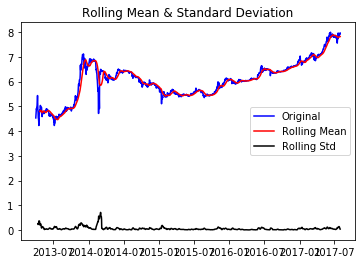

ADF Stastistic: -0.401896
p-value: 0.909782
The graph is non stationery
Critical values:
	1%: -3.435 
	5%: -2.863 
	10%: -2.568 


In [27]:
ts_log = np.log(ts)
plt.plot(ts_log, color = 'green')
plt.show()

test_stationarity(ts_log)

Remove trend and seasonality with differencing
--------------

#### Due to this the mean is stabilized and hence the chances of stationarity of time series are increased.

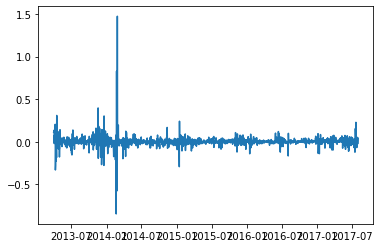

In [29]:
# Shift index by desired number of periods with an optional time freq.
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

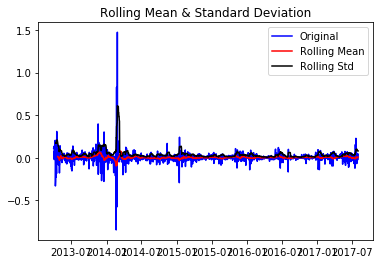

ADF Stastistic: -15.699003
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.435 
	5%: -2.863 
	10%: -2.568 


In [30]:
ts_log_difopna(inplace=True)
test_stationarity(ts_log_diff)

Auto Regressive model
-----------------

#### 현재의 값이 과거의 값에 의존하는 경우 사용되는 모델

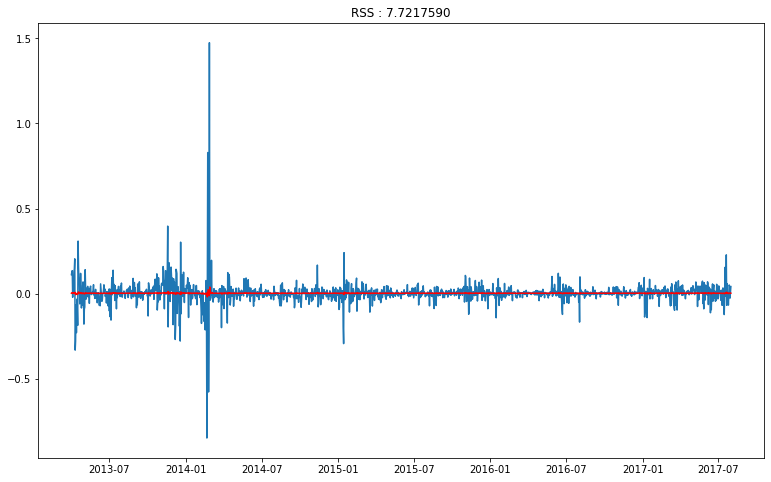

In [44]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order= (1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(13,8))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color = 'red')
plt.title('RSS : %.7f'% sum((results_ARIMA.fittedvalues - ts_log_diff) ** 2))
plt.show()

Moving Average Model
-----------

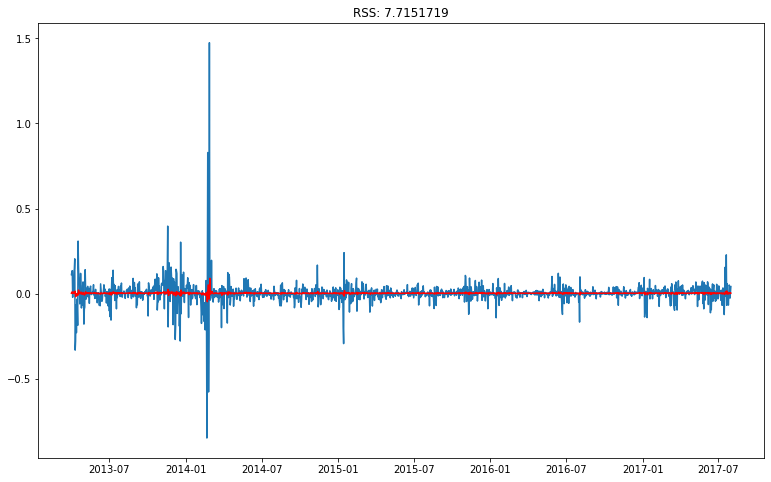

In [42]:
model = ARIMA(ts_log, order=(0,1,1))  
results_MA = model.fit(disp=-1)  
plt.figure(figsize=(13,8))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plt.show()

Auto Regressive Integrated Moving Average Model
--------------

#### It is a combination of both AR and MA models. It makes the time series stationary by itself through the process of differencing.   
#### Therefore differencing need not be done explicitly for ARIMA model

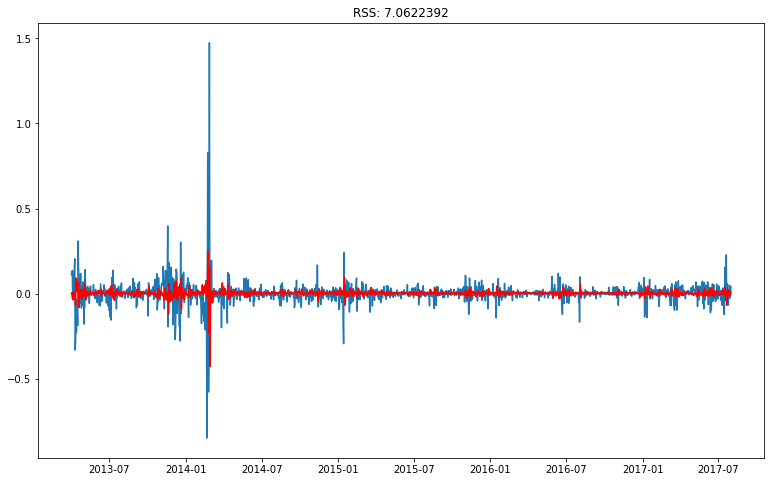

In [43]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2,1,0))  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(13,8))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

Printing Predicted vs Expected Values...


predicted = 1239.780992,   expected = 1249.140015,   error = 0.749237  %
predicted = 1254.822959,   expected = 1248.180054,   error = 0.532207  %
predicted = 1248.348459,   expected = 1264.310059,   error = 1.262475  %
predicted = 1267.939176,   expected = 1286.630005,   error = 1.452696  %
predicted = 1285.235174,   expected = 1332.910034,   error = 3.576750  %
predicted = 1330.461171,   expected = 1329.619995,   error = 0.063264  %
predicted = 1318.252670,   expected = 1336.280029,   error = 1.349070  %
predicted = 1340.493613,   expected = 1351.910034,   error = 0.844466  %
predicted = 1353.432659,   expected = 1415.810059,   error = 4.405775  %
predicted = 1416.337627,   expected = 1445.930054,   error = 2.046602  %
predicted = 1430.149842,   expected = 1485.550049,   error = 3.729272  %
predicted = 1480.933158,   expected = 1516.760010,   error = 2.362065  %
predicted = 1509.002536,   expected = 1507.770020,   error = 0.081744  %
predicte

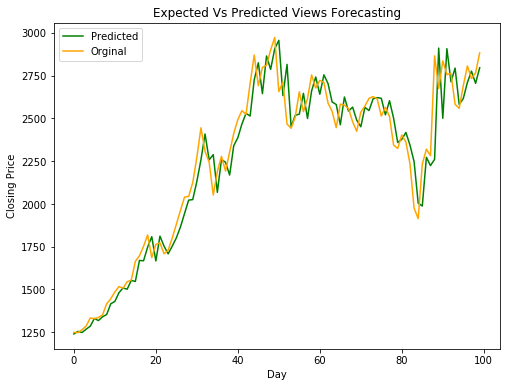

In [46]:
size = int(len(ts_log)-100)

# Divide into train and test
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')

# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. 
# We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit(disp=-1)
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    
        
    original_value = test_arima[t]
    history.append(original_value)
    
    pred_value = np.exp(pred_value)
    
    
    original_value = np.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
plt.figure(figsize=(8, 6))
test_day = [t
           for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plt.plot(test_day, predictions, color= 'green')
plt.plot(test_day, originals, color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend(labels)
plt.show()

Reference
------

#### https://towardsdatascience.com/bitcoin-price-prediction-using-time-series-forecasting-9f468f7174d3